In [1]:
# Numpy = calculate
import numpy as np

# Pandas = dataframe
import pandas as pd
from pandas.tseries.offsets import DateOffset
pd.set_option('display.max_rows',100)

# Re = regex
import re

# Seaborn = visualization and dataset
import seaborn as sns

# matplotlib = visualization
import matplotlib.pyplot as plt

# warnings = ignore warning
import warnings
warnings.filterwarnings('ignore')

# scipy = ttest, chi square, non parametric
from scipy.stats import ttest_1samp, ttest_ind, f_oneway, chi2_contingency, wilcoxon, mannwhitneyu, kruskal

# statsmodels = ztest
from statsmodels.stats.proportion import proportions_ztest, proportions_ztest
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm

# cufflinks = ztest
import cufflinks as cf

# Folium
import folium
import geocoder
from folium.plugins import MarkerCluster, HeatMap
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from itertools import combinations
from math import atan2, degrees

# Kohort
from datetime import datetime

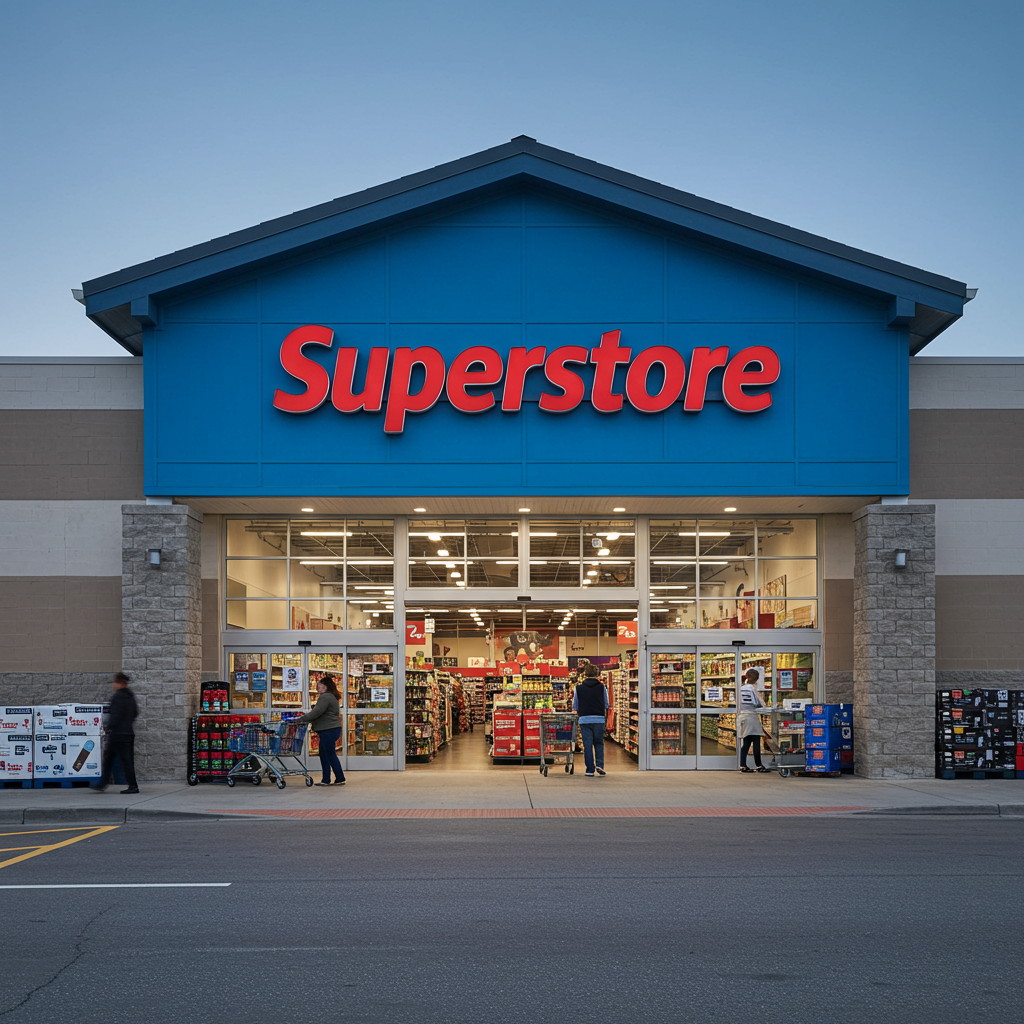
Dalam proyek ini, kita mengeksplorasi data penjualan Superstore untuk memahami lebih dalam bagaimana produk, pelanggan, diskon, dan wilayah mempengaruhi penjualan dan profit. Lewat analisis dan visualisasi data, kita mencoba menemukan pola-pola menarik yang bisa membantu Superstore mengambil keputusan bisnis yang lebih tepat — misalnya, kapan dan di mana diskon itu efektif, kategori mana yang paling menguntungkan, atau area mana yang butuh perhatian lebih. Hasil akhirnya, kita ingin kasih insight yang simpel tapi impactful untuk mendorong pertumbuhan bisnis.

### Stackholder

Stakeholders utama dalam optimasi bisnis ini mencakup **manajemen Superstore** yang bertanggung jawab atas keputusan strategis dan perencanaan, **tim pemasaran** yang akan merancang kampanye untuk meningkatkan penjualan, serta **tim logistik** dan **pengelolaan inventaris** yang berfokus pada efisiensi operasional dan pengelolaan stok. Selain itu, **tim penjualan** dan **layanan pelanggan** memainkan peran penting dalam menjaga hubungan dengan pelanggan untuk meningkatkan retensi.

### Problem Statement
Superstore menghadapi tantangan dalam meningkatkan profitabilitas dan kepuasan pelanggan meskipun volume penjualan sudah tinggi. Pengelolaan pengiriman yang kurang efisien dan strategi harga serta diskon yang tidak optimal berkontribusi pada tingginya biaya operasional. Selain itu, pengelolaan pesanan besar dan pengalaman pelanggan yang kurang memadai mempengaruhi daya tarik dan retensi pelanggan.

### Goal
Tujuan utama adalah meningkatkan profitabilitas dengan mengoptimalkan strategi harga dan diskon. Selain itu, Superstore perlu memperbaiki manajemen pengiriman untuk mengurangi biaya dan waktu pengiriman. Pengelolaan inventaris juga perlu dioptimalkan agar stok barang lebih seimbang, sementara pengalaman pelanggan harus ditingkatkan melalui pelayanan yang lebih cepat dan responsif.

In [3]:
df=pd.read_csv('input/sample.csv',encoding='latin1')

df['Order Date'] = pd.to_datetime(df['Order Date'], infer_datetime_format=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], infer_datetime_format=True)

# Filter Date
start_date = pd.to_datetime('2017-10-01')
end_date = pd.to_datetime('2017-12-30')

df = df[~df['Order Date'].between(start_date, end_date)]

## Data Cleaning

In [5]:
# Check Missing
miss=100*df.isna().sum()/len(df)
miss

Row ID           0.0
Order ID         0.0
Order Date       0.0
Ship Date        0.0
Ship Mode        0.0
Customer ID      0.0
Customer Name    0.0
Segment          0.0
Country          0.0
City             0.0
State            0.0
Postal Code      0.0
Region           0.0
Product ID       0.0
Category         0.0
Sub-Category     0.0
Product Name     0.0
Sales            0.0
Quantity         0.0
Discount         0.0
Profit           0.0
dtype: float64

In [6]:
# Drop duplicate
df.drop_duplicates(inplace=True)

In [7]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## Data Preprocessing

### DF -> Cohort

**Analysis Distance**

In [11]:
analysis = df.copy()
analysis['Cohort Month'] = analysis.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M')
analysis['Current Transaction Month']=analysis['Order Date'].dt.to_period('M')
analysis['Period Distance'] = (
    (analysis['Current Transaction Month'].dt.year - analysis['Cohort Month'].dt.year) * 12 +
    (analysis['Current Transaction Month'].dt.month - analysis['Cohort Month'].dt.month)
)

analysis=analysis[['Customer ID','Cohort Month','Current Transaction Month', 'Period Distance']]
analysis

,Customer ID,Cohort Month,Current Transaction Month,Period Distance
0,CG-12520,2015-10,2016-11,13
1,CG-12520,2015-10,2016-11,13
2,DV-13045,2016-06,2016-06,0
3,SO-20335,2015-10,2015-10,0
4,SO-20335,2015-10,2015-10,0
...,...,...,...,...
9989,TB-21400,2014-01,2014-01,0
9990,DB-13060,2014-03,2017-02,35
9991,DB-13060,2014-03,2017-02,35
9992,DB-13060,2014-03,2017-02,35


In [12]:
check=analysis.copy()
check=check[check['Period Distance']!=0]

check['Period Distance to Second Period']=analysis.groupby('Customer ID')['Period Distance'].transform('min')

check=check[['Customer ID','Period Distance to Second Period']]
check=check.drop_duplicates()

check.describe()

,Period Distance to Second Period
count,763.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


**Cohort**\
`cohort_quarter`\
`period_distance`\
`percentage`\
`line percentage`

In [14]:
cohort=analysis.copy()

cohort.sort_values(by='Cohort Month')

,Customer ID,Cohort Month,Current Transaction Month,Period Distance
3231,ND-18370,2014-01,2017-04,39
5736,MV-17485,2014-01,2014-01,0
5737,MV-17485,2014-01,2014-01,0
5753,LC-17050,2014-01,2016-02,25
1357,ND-18370,2014-01,2016-05,28
...,...,...,...,...
1620,JC-15385,2017-07,2017-07,0
6758,TC-21145,2017-09,2017-09,0
6755,TC-21145,2017-09,2017-09,0
6756,TC-21145,2017-09,2017-09,0


In [15]:
min_cohort = cohort['Cohort Month'].min()
min_current = cohort['Current Transaction Month'].min()

cohort['Cohort 5'] = ((cohort['Cohort Month'].dt.year - min_cohort.year) * 12 +
                      (cohort['Cohort Month'].dt.month - min_cohort.month)) // 5 + 1

cohort['Current 5'] = ((cohort['Current Transaction Month'].dt.year - min_current.year) * 12 +
                      (cohort['Current Transaction Month'].dt.month - min_current.month)) // 5 + 1


cohort=cohort[['Customer ID','Cohort 5','Current 5']]
cohort

,Customer ID,Cohort 5,Current 5
0,CG-12520,5,7
1,CG-12520,5,7
2,DV-13045,6,6
3,SO-20335,5,5
4,SO-20335,5,5
...,...,...,...
9989,TB-21400,1,1
9990,DB-13060,1,8
9991,DB-13060,1,8
9992,DB-13060,1,8


In [16]:
cohort_retention=cohort.groupby(['Cohort 5','Current 5'])['Customer ID'].nunique().reset_index().rename(columns={'Customer ID':'Count User'})

cohort_retention['Period Distance']=cohort_retention['Current 5']-cohort_retention['Cohort 5']

cohort_start = pd.to_datetime('2014-01')

In [17]:
def cohortLabel(group_num):
    start_date = cohort_start + DateOffset(months=(group_num - 1) * 5)
    end_date = start_date + DateOffset(months=4)
    return f"{start_date.strftime('%Y-%m')} to {end_date.strftime('%Y-%m')}"

In [18]:
cohort_retention['Cohort 5'] = cohort_retention['Cohort 5'].apply(cohortLabel)
cohort_retention=cohort_retention[['Cohort 5', 'Period Distance', 'Count User']]

cohort_retention

,Cohort 5,Period Distance,Count User
0,2014-01 to 2014-05,0,233
1,2014-01 to 2014-05,1,84
2,2014-01 to 2014-05,2,94
3,2014-01 to 2014-05,3,86
4,2014-01 to 2014-05,4,119
5,2014-01 to 2014-05,5,92
6,2014-01 to 2014-05,6,130
7,2014-01 to 2014-05,7,111
8,2014-01 to 2014-05,8,137
9,2014-06 to 2014-10,0,251


In [19]:
cohort_retention_0=cohort_retention.groupby(['Cohort 5']).agg({'Count User':'max'})
cohort_retention_0

,Count User
Cohort 5,
2014-01 to 2014-05,233
2014-06 to 2014-10,251
2014-11 to 2015-03,143
2015-04 to 2015-08,56
2015-09 to 2016-01,54
2016-02 to 2016-06,30
2016-07 to 2016-11,13
2016-12 to 2017-04,6
2017-05 to 2017-09,4


In [20]:
cohort_retention_percent=cohort_retention.set_index(['Cohort 5']).div(cohort_retention_0,level='Cohort 5').reset_index()
cohort_retention_percent

,Cohort 5,Count User,Period Distance
0,2014-01 to 2014-05,1.000000,NaN
1,2014-01 to 2014-05,0.360515,NaN
2,2014-01 to 2014-05,0.403433,NaN
3,2014-01 to 2014-05,0.369099,NaN
4,2014-01 to 2014-05,0.510730,NaN
5,2014-01 to 2014-05,0.394850,NaN
6,2014-01 to 2014-05,0.557940,NaN
7,2014-01 to 2014-05,0.476395,NaN
8,2014-01 to 2014-05,0.587983,NaN
9,2014-06 to 2014-10,1.000000,NaN


In [21]:
cohort_retention_percent['Period Distance']=cohort_retention['Period Distance']
cohort_retention_percent['Percentage']=cohort_retention_percent['Count User']
cohort_retention_percent['Line Percentage']=cohort_retention_percent['Count User']*100

final_cohort=cohort_retention_percent[['Cohort 5','Period Distance','Percentage', 'Line Percentage']]
final_cohort

,Cohort 5,Period Distance,Percentage,Line Percentage
0,2014-01 to 2014-05,0,1.000000,100.000000
1,2014-01 to 2014-05,1,0.360515,36.051502
2,2014-01 to 2014-05,2,0.403433,40.343348
3,2014-01 to 2014-05,3,0.369099,36.909871
4,2014-01 to 2014-05,4,0.510730,51.072961
5,2014-01 to 2014-05,5,0.394850,39.484979
6,2014-01 to 2014-05,6,0.557940,55.793991
7,2014-01 to 2014-05,7,0.476395,47.639485
8,2014-01 to 2014-05,8,0.587983,58.798283
9,2014-06 to 2014-10,0,1.000000,100.000000


In [22]:
pivot=final_cohort.pivot(index='Cohort 5',columns='Period Distance',values='Percentage')
pivot

pivot.to_csv('output/pivot.csv', index=False)

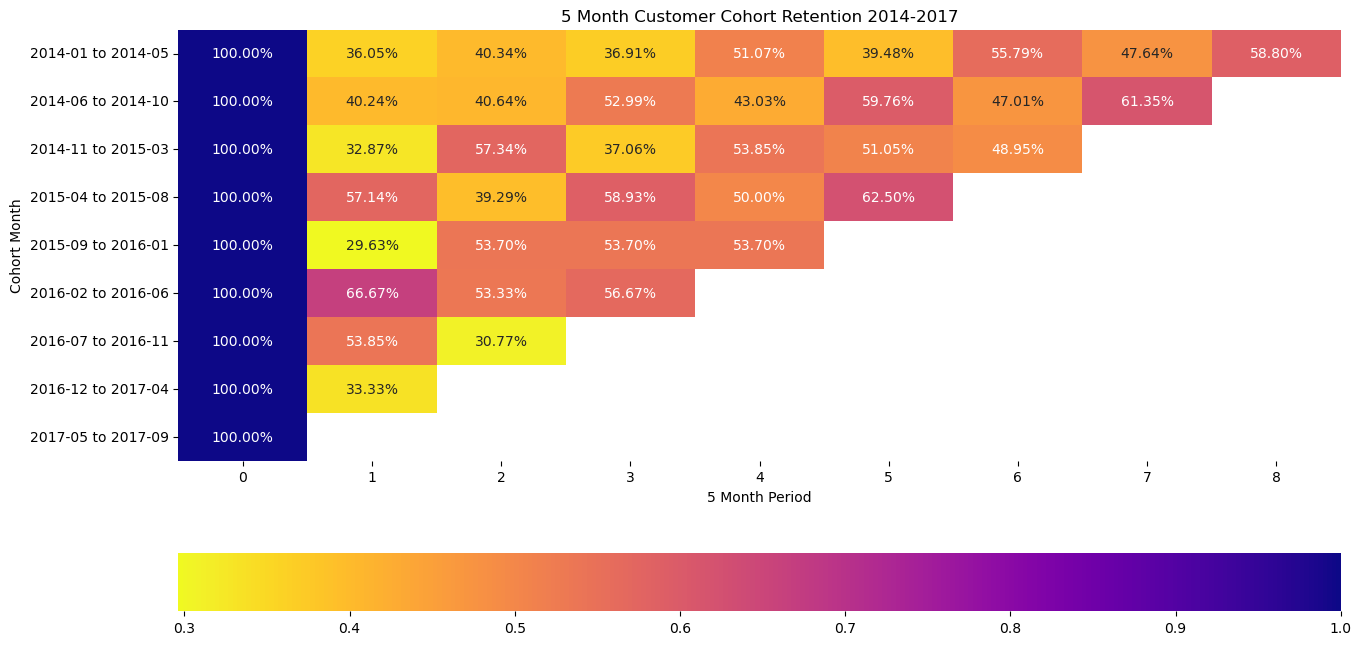

In [23]:
plt.figure(figsize=(15,8))
sns.heatmap(
    data=pivot,
    annot=True,fmt='.2%',
    cbar_kws={'orientation':'horizontal'},
    cmap='plasma_r'
)
plt.title('5 Month Customer Cohort Retention 2014-2017')
plt.xlabel('5 Month Period')
plt.ylabel('Cohort Month')

plt.show()

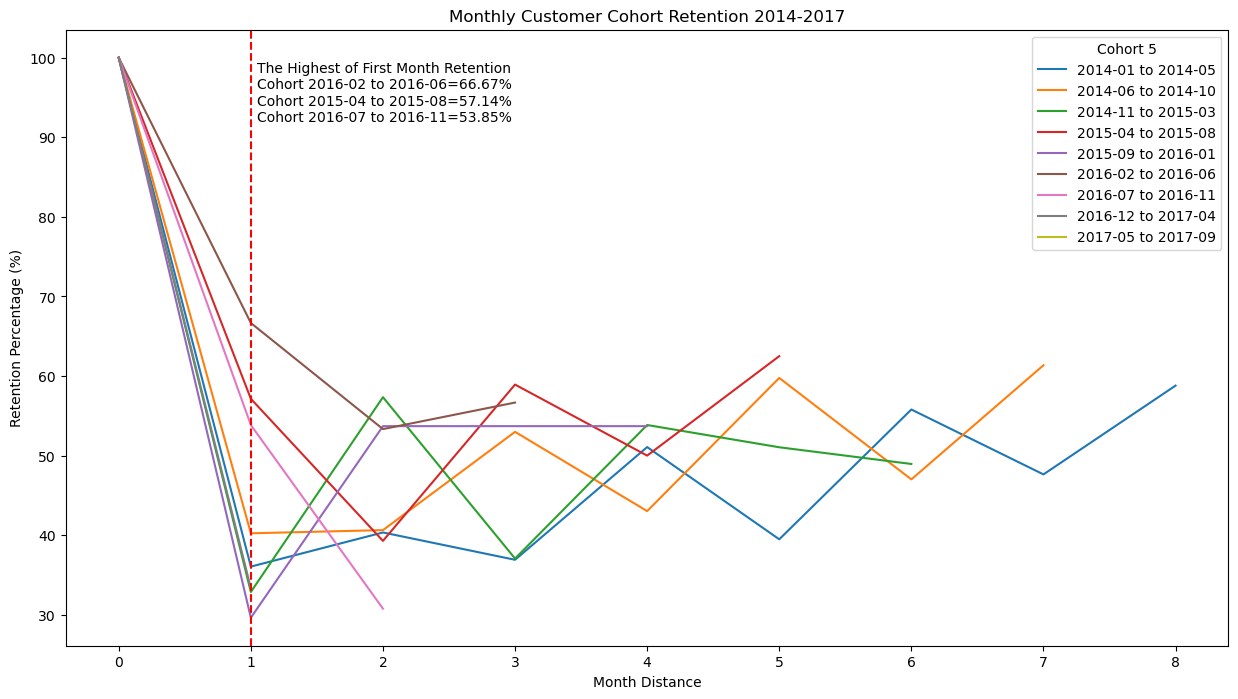

In [24]:
plt.figure(figsize=(15,8))

sns.lineplot(data=final_cohort,x='Period Distance',y='Line Percentage',hue='Cohort 5')

plt.axvline(x=1,linestyle='--',color='red')

top_3=final_cohort[final_cohort['Period Distance']==1].sort_values(by='Line Percentage',ascending=False).head()
top_3_name=top_3['Cohort 5'].to_list()
top_3_percentage=top_3['Line Percentage'].to_list()

text=f'''
The Highest of First Month Retention
Cohort {top_3_name[0]}={0.01*top_3_percentage[0]:.2%}
Cohort {top_3_name[1]}={0.01*top_3_percentage[1]:.2%}
Cohort {top_3_name[2]}={0.01*top_3_percentage[2]:.2%}
'''

plt.text(1.05,90,text)

plt.xlabel('Month Distance')
plt.ylabel('Retention Percentage (%)')
plt.title('Monthly Customer Cohort Retention 2014-2017')
plt.show()

### Data

1. `Order ID`
1. `Order Date`
1. `Customer Name`
1. `City`
1. `Segment`
1. `Category`
1. `Sub-Category`
1. `Discount`
1. `Sales`
1. `Profit`

In [27]:
data=df[[
    'Order ID', 
    'Order Date',
    'Customer Name',
    'City',
    'Segment',
    'Category',
    'Sub-Category',
    'Quantity',
    'Discount',
    'Sales',
    'Profit'
]]

In [28]:
data['Order Date'] = pd.to_datetime(data['Order Date'], infer_datetime_format=True)

In [29]:
data

,Order ID,Order Date,Customer Name,City,Segment,Category,Sub-Category,Quantity,Discount,Sales,Profit
0,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Bookcases,2,0.00,261.9600,41.9136
1,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Chairs,3,0.00,731.9400,219.5820
2,CA-2016-138688,2016-06-12,Darrin Van Huff,Los Angeles,Corporate,Office Supplies,Labels,2,0.00,14.6200,6.8714
3,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Furniture,Tables,5,0.45,957.5775,-383.0310
4,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Office Supplies,Storage,2,0.20,22.3680,2.5164
...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-110422,2014-01-21,Tom Boeckenhauer,Miami,Consumer,Furniture,Furnishings,3,0.20,25.2480,4.1028
9990,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Furniture,Furnishings,2,0.00,91.9600,15.6332
9991,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Technology,Phones,2,0.20,258.5760,19.3932
9992,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Office Supplies,Paper,4,0.00,29.6000,13.3200


### Canva Data

#### Card: Repeat Purchase Rate
`Customer Name`

In [32]:
customer_counts = data['Customer Name'].value_counts().reset_index()
customer_counts.columns = ['Customer Name', 'Order Count']

data = pd.merge(data, customer_counts, on='Customer Name', how='left')

data['isRepeat'] = data['Order Count'].apply(lambda x: 'Yes' if x > 1 else 'No')
data

,Order ID,Order Date,Customer Name,City,Segment,Category,Sub-Category,Quantity,Discount,Sales,Profit,Order Count,isRepeat
0,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Bookcases,2,0.00,261.9600,41.9136,5,Yes
1,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Chairs,3,0.00,731.9400,219.5820,5,Yes
2,CA-2016-138688,2016-06-12,Darrin Van Huff,Los Angeles,Corporate,Office Supplies,Labels,2,0.00,14.6200,6.8714,4,Yes
3,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Furniture,Tables,5,0.45,957.5775,-383.0310,13,Yes
4,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Office Supplies,Storage,2,0.20,22.3680,2.5164,13,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770,CA-2014-110422,2014-01-21,Tom Boeckenhauer,Miami,Consumer,Furniture,Furnishings,3,0.20,25.2480,4.1028,17,Yes
8771,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Furniture,Furnishings,2,0.00,91.9600,15.6332,9,Yes
8772,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Technology,Phones,2,0.20,258.5760,19.3932,9,Yes
8773,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Office Supplies,Paper,4,0.00,29.6000,13.3200,9,Yes


In [33]:
a=data[data['isRepeat']!='Yes']
len(a)

11

#### Scatter Plot: Discount vs Profit?
`Discount`, `Profit`, `Order ID`
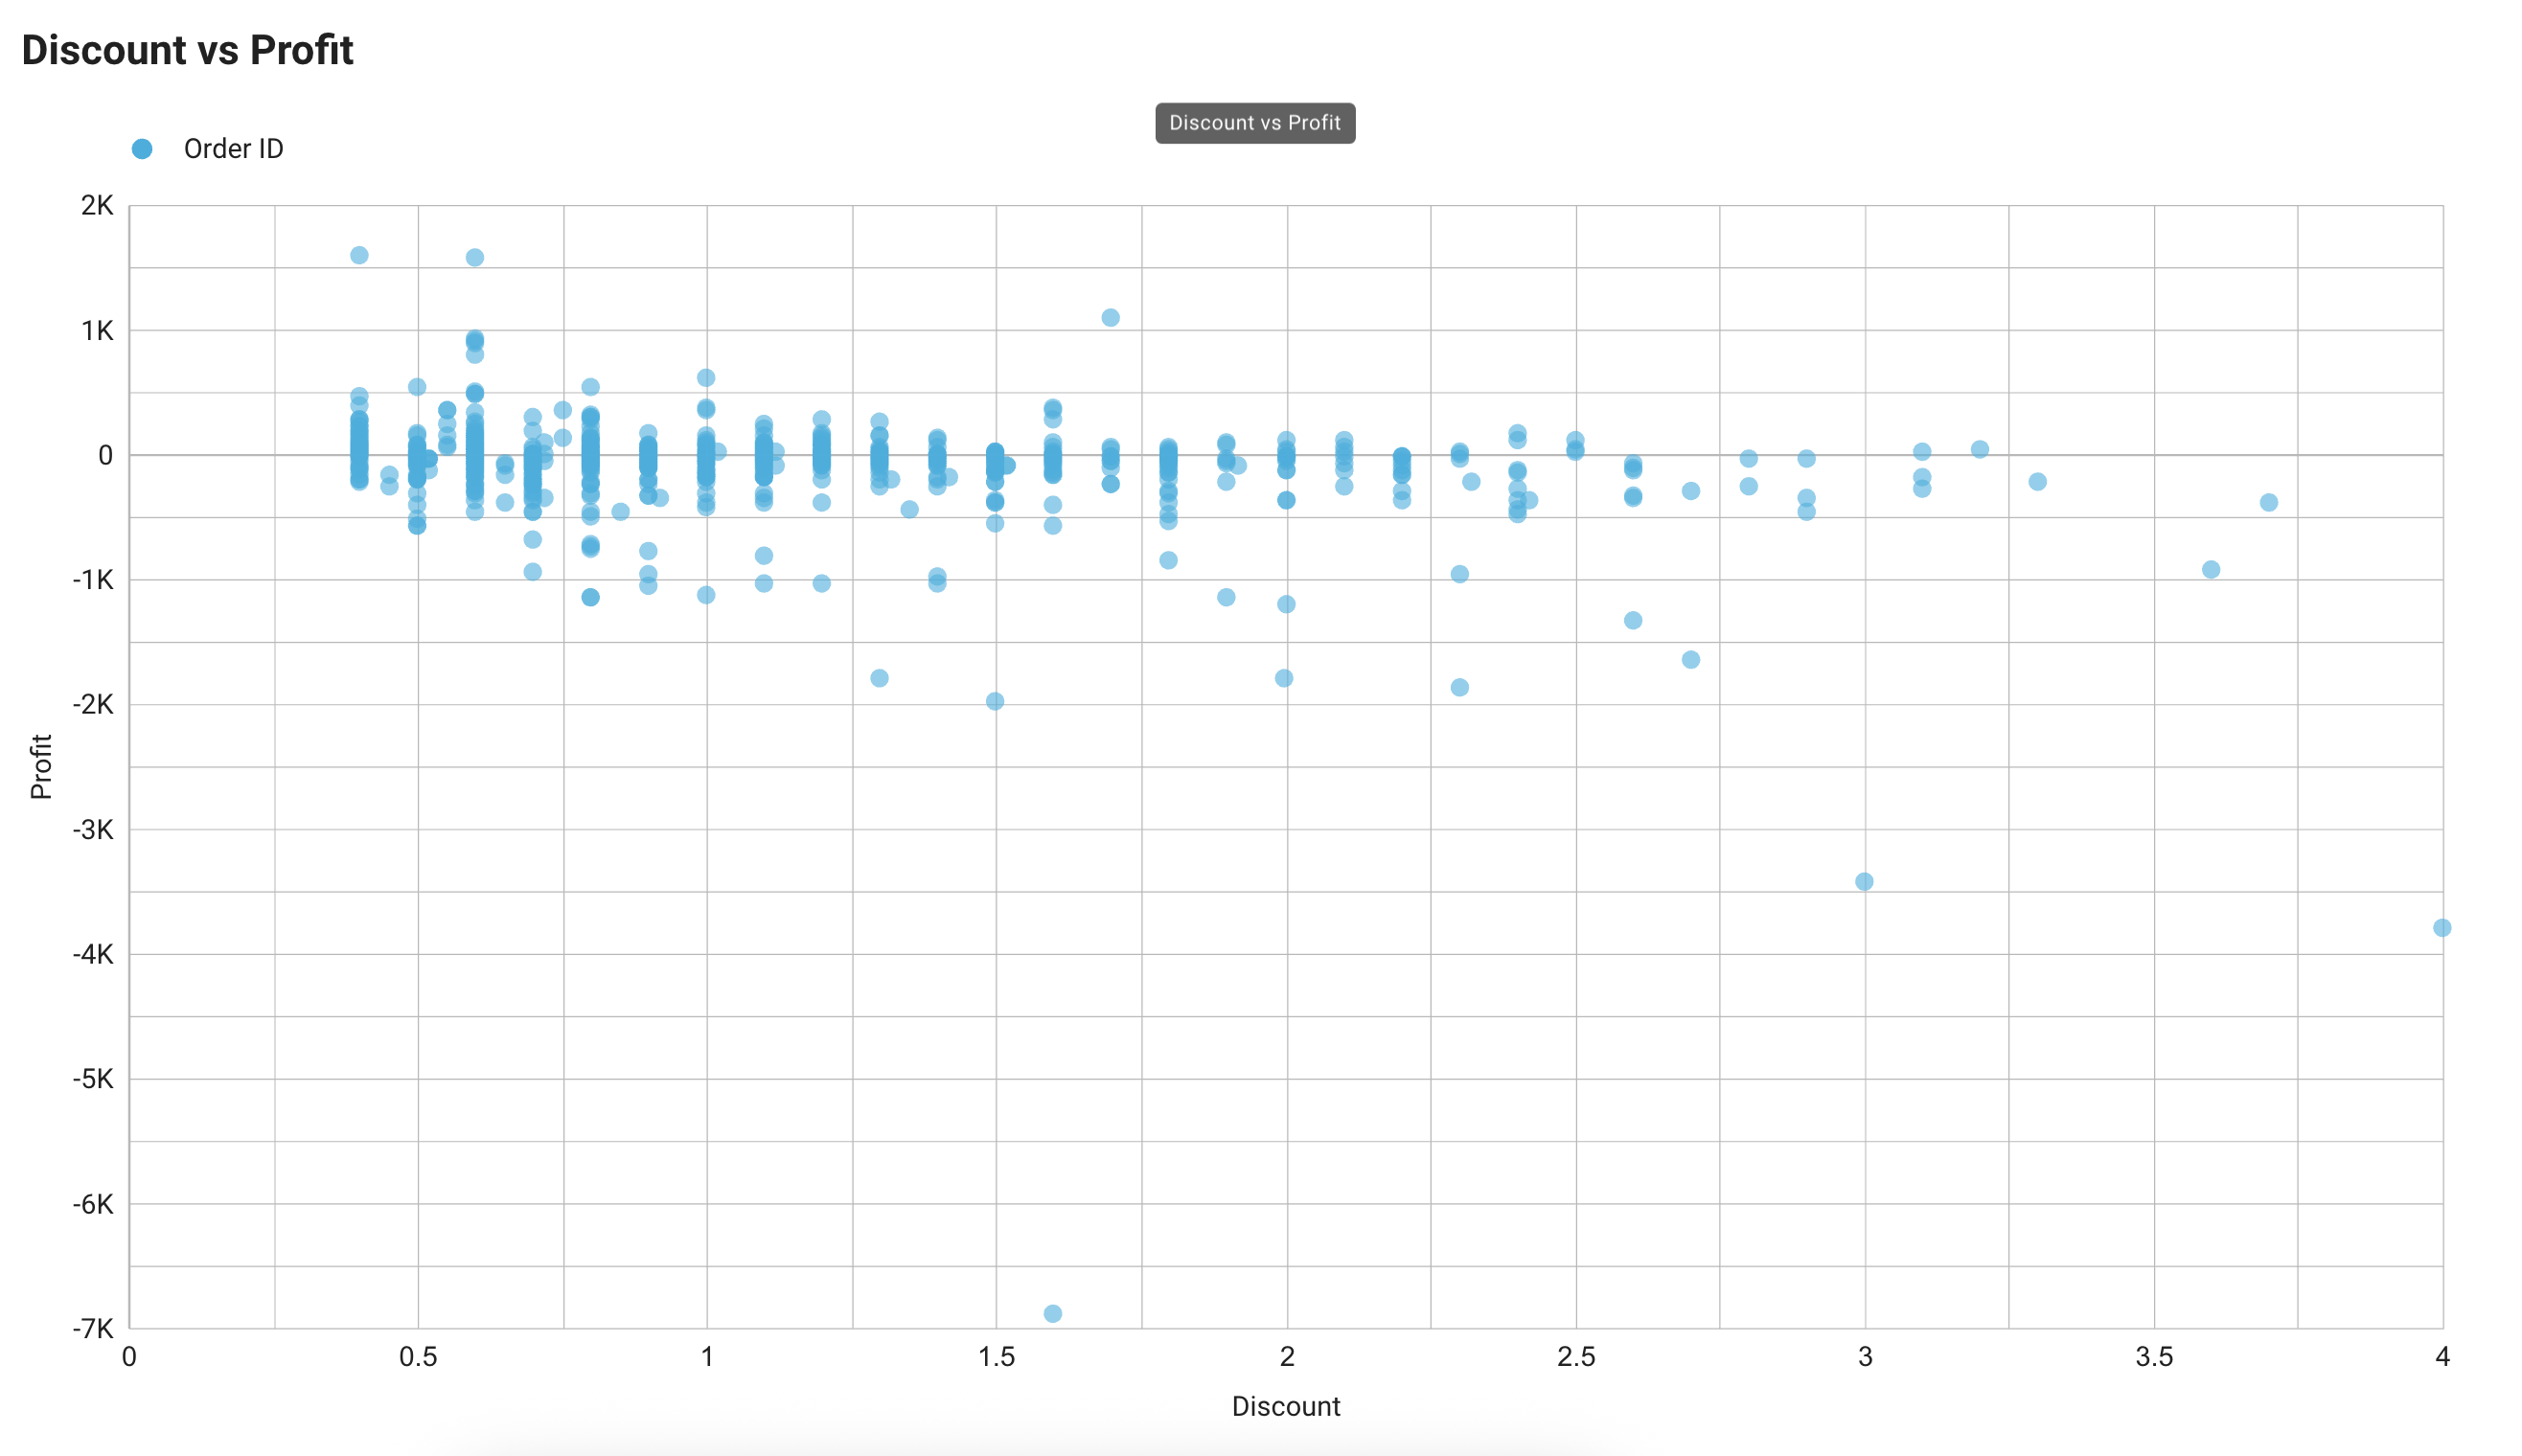

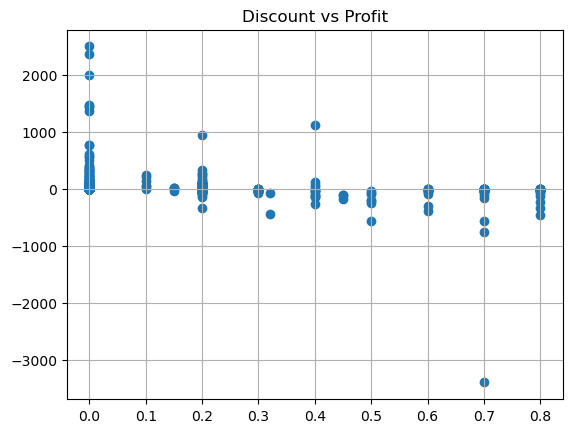

In [35]:
n=round(len(data)*10/100) #menentukan sampel sebesar 1 %

scatter=data.sample(n)
scatter=scatter[['Order ID', 'Discount', 'Profit']]


plt.scatter(
    scatter['Discount'], # X
    scatter['Profit'] # Y
)
plt.title('Discount vs Profit')
plt.grid()
plt.show()

#### 

## Export

In [38]:
data.columns

Index(['Order ID', 'Order Date', 'Customer Name', 'City', 'Segment',
       'Category', 'Sub-Category', 'Quantity', 'Discount', 'Sales', 'Profit',
       'Order Count', 'isRepeat'],
      dtype='object')

In [39]:
data=data[[
    'Order ID',
    'Order Date',
    'Customer Name',
    'City',
    'Segment',
    'Category',
    'Sub-Category',
    'Quantity',
    'Discount',
    'Sales',
    'Profit',
    'isRepeat'
]]

In [40]:
data.to_csv('output/data.csv', index=False)
scatter.to_csv('output/scatter.csv', index=False)

final_cohort.to_csv('output/cohort.csv', index=False)

In [79]:
data

,Order ID,Order Date,Customer Name,City,Segment,Category,Sub-Category,Quantity,Discount,Sales,Profit,isRepeat
0,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Bookcases,2,0.00,261.9600,41.9136,Yes
1,CA-2016-152156,2016-11-08,Claire Gute,Henderson,Consumer,Furniture,Chairs,3,0.00,731.9400,219.5820,Yes
2,CA-2016-138688,2016-06-12,Darrin Van Huff,Los Angeles,Corporate,Office Supplies,Labels,2,0.00,14.6200,6.8714,Yes
3,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Furniture,Tables,5,0.45,957.5775,-383.0310,Yes
4,US-2015-108966,2015-10-11,Sean O'Donnell,Fort Lauderdale,Consumer,Office Supplies,Storage,2,0.20,22.3680,2.5164,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
8770,CA-2014-110422,2014-01-21,Tom Boeckenhauer,Miami,Consumer,Furniture,Furnishings,3,0.20,25.2480,4.1028,Yes
8771,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Furniture,Furnishings,2,0.00,91.9600,15.6332,Yes
8772,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Technology,Phones,2,0.20,258.5760,19.3932,Yes
8773,CA-2017-121258,2017-02-26,Dave Brooks,Costa Mesa,Consumer,Office Supplies,Paper,4,0.00,29.6000,13.3200,Yes
